In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import ensemble
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Load dataset

In [ ]:
train = pd.read_csv('drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv')
test = pd.read_csv('drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv')

In [ ]:
df_train = train.copy()
df_test = test.copy()

# Examine NaN values

In [ ]:
df_train.isnull().any().sum()

0

In [ ]:
df_test.isnull().any().sum()

0

# Separating data and label

In [ ]:
X_train= df_train.drop(['label'],axis = 1)
y_train = df_train['label']
X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']  # y_test should be labels

# Normalization
The Pixel Values are often stored as Integer Numbers in the range 0 to 255, the range that a single 8-bit byte can offer. They need to be scaled down to [0,1] in order for Optimization Algorithms to work much faster. Here, we acheive Zero Mean and Unit Variance.

In [ ]:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')  # X_test should be features
X_train /= 255.0
X_test /= 255.0  # X_test should be features

# Dimensionality Reduction using PCA
The advantage of PCA (and dimensionality reduction in general) is that it compresses the data down to something that is more effectively modeled. This means that it will, for example, compress away highly correlated and colinear variables, a useful thing to do when trying to run models that would otherwise be sensitive to these sort of data problems.

In [ ]:
# Reshape the data to 4D (num_samples, height, width, num_channels)
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

In [ ]:
# Create augmented images
X_augmented = []
y_augmented = []
for X_batch, y_batch in datagen.flow(X_train_reshaped, y_train, batch_size=X_train_reshaped.shape[0]):
    X_augmented.append(X_batch)
    y_augmented.append(y_batch)
    break  # We only want to augment the data once, so we break the loop after the first batch

# Convert lists to numpy arrays
X_augmented = np.concatenate(X_augmented)
y_augmented = np.concatenate(y_augmented)

# Flatten the augmented data
X_augmented_flattened = X_augmented.reshape(X_augmented.shape[0], -1)

# Flatten the original training data
X_train_flattened = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Concatenate the original and the augmented data
X_all_flattened = np.concatenate([X_train_flattened, X_augmented_flattened])
y_all = np.concatenate([y_train, y_augmented])

# Evaluate the model

In [ ]:
seed = 42

# Apply PCA to the concatenated data
pca = PCA(n_components=150, random_state=seed)
X_all_pca = pca.fit_transform(X_all_flattened)

# SVM 모델 정의
svc1 = SVC(C=4.419450186421157, gamma='scale', kernel='rbf', random_state=seed, probability=True)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# To store the models for each fold
models = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(X_all_pca, y_all):

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  svc1.fit(X_all_pca[train], y_all[train])

  # Save the model
  models.append(svc1)

  fold_no = fold_no + 1

# Select the best model
best_model = models[np.argmax([accuracy_score(y_all, model.predict(X_all_pca)) for model in models])]

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...


# Predicting the models

***SVM Report and Analysis***

In [15]:
# Reshape the test data to 4D (num_samples, height, width, num_channels)
X_test_reshaped = X_test.values.reshape(-1, 28, 28, 1)

# Flatten the test data
X_test_flattened = X_test_reshaped.reshape(X_test_reshaped.shape[0], -1)

# Apply PCA transform to the test data
X_test_pca = pca.transform(X_test_flattened)

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_pca)

# Calculate the accuracy score
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Print the test accuracy score
print("Test Accuracy score: {}".format(test_accuracy))

# Print the classification report
print(metrics.classification_report(y_test, y_test_pred))

Test Accuracy score: 0.9051
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.85      0.85      1000
           3       0.91      0.93      0.92      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.95      0.96      1000
           6       0.77      0.71      0.74      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



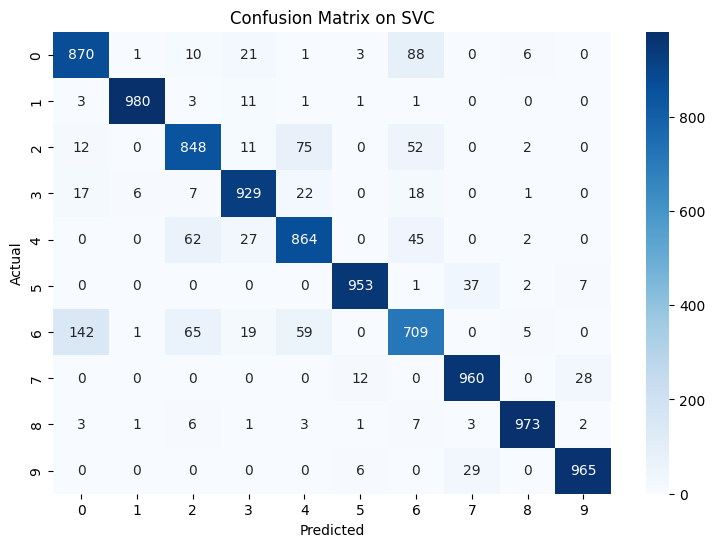

In [16]:
con_matrix = pd.crosstab(pd.Series(y_test.values.flatten(), name='Actual'), pd.Series(y_test_pred, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on SVC")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()